In [248]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import optax

import lib

In [227]:
data = np.loadtxt("experimental_data/Daou_HVC_2022_Data/Data2022-50KhZ/Data2022-50KhZ/7-7-2022/Red 171/Neuron 2/epoch_1.txt")
# data = np.loadtxt("experimental_data/Daou_HVC_2022_Data/Data2022-50KhZ/Data2022-50KhZ/11-30-2022/Lilac 160/Neuron 5/epoch_1.txt")
stimulus = np.copy(data[:, 0])
voltage = np.copy(data[:, 1])
print("length of data: ", data.shape[0])

length of data:  750000


In [228]:
"smooth the data, get rid of spikes"
kernel_length = 2000
smoothed_V = np.convolve(np.ones(kernel_length)/kernel_length, voltage, mode='same')
smoothed_V = smoothed_V[kernel_length//2:-kernel_length//2]
stimulus = stimulus[kernel_length//2:-kernel_length//2]

In [229]:
"""down sample the data"""
smoothed_V = smoothed_V[::6]
stimulus = stimulus[::6]
print("length of data: ", stimulus.shape[0])

length of data:  124667


In [252]:
train_len = 60000
I_train = stimulus[5000:5000+train_len]
V_train = smoothed_V[5000:5000+train_len]
test_len = 40000
I_test = stimulus[70000:70000+test_len]
V_test = smoothed_V[70000:70000+test_len]

In [231]:
time_delay = 50
time_delay_dim = 10
time_spacing = 0.12
n_centers = 500

Text(0, 0.5, 'V(t) exact')

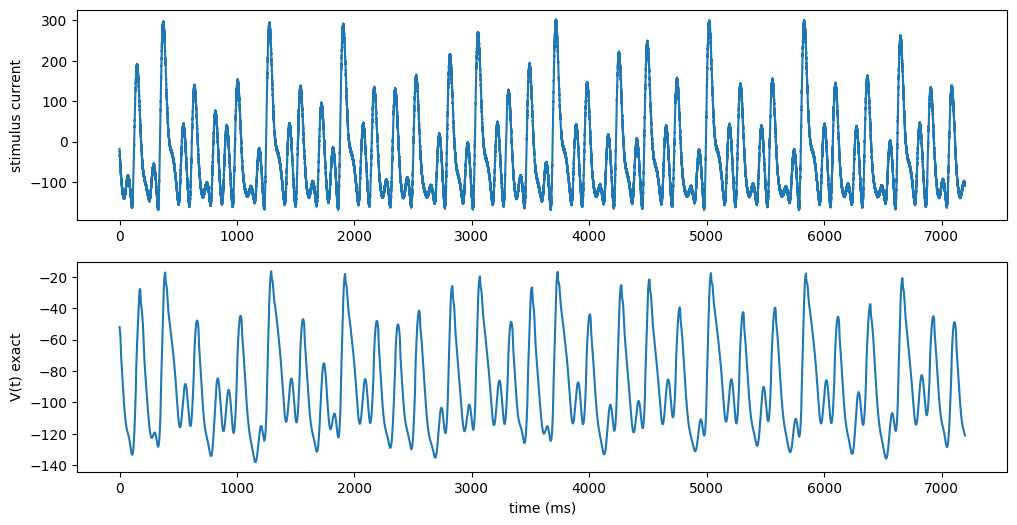

In [232]:
"""plot training data"""
fig, axes = plt.subplots(2, 1,  figsize=(12, 6))

axes[0].plot(np.arange(train_len)*time_spacing, I_train)
axes[0].set_ylabel("stimulus current")
axes[1].plot(np.arange(train_len)*time_spacing, V_train)
axes[1].set_xlabel("time (ms)")
axes[1].set_ylabel("V(t) exact")

Text(0, 0.5, 'V(t-tau)')

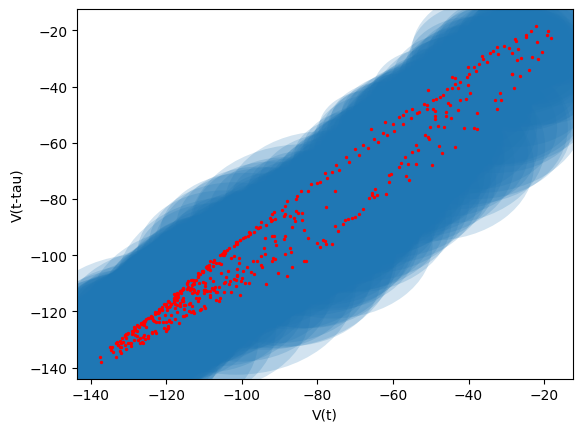

In [234]:
"""get centers and R, plot centers and the range of each center"""
centers, R = lib.train.get_centers_and_R(V_train, time_delay, time_delay_dim, n_centers, n_neighbors=8)
for i in range(len(centers)):
    circle = plt.Circle((centers[i, 1], centers[i, 0]), radius=np.sqrt(1/R[i]), alpha=0.2, edgecolor='none')
    plt.gca().add_artist(circle)
plt.scatter(centers[:, 1], centers[:, 0], s=2, c="red")
plt.xlabel("V(t)")
plt.ylabel("V(t-tau)")

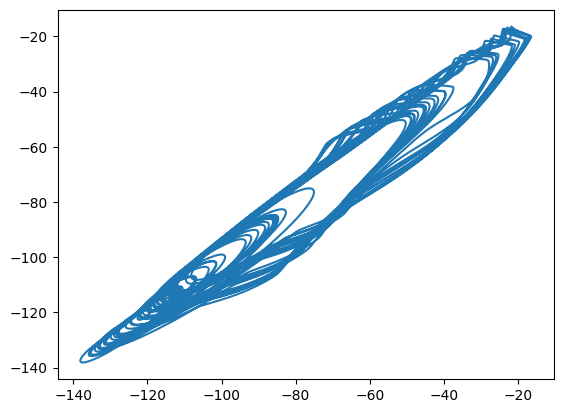

In [235]:
"""2d time delay space of the training data"""
plt.plot(V_train[time_delay:], V_train[:-time_delay])

In [236]:
"""RBF part training by regression"""
beta = 0
regression_train = lib.train.train_by_regression(centers, V_train, I_train, time_delay, time_delay_dim, time_spacing=time_spacing, beta=beta, R=R, fixed_C=False, weight_C=1.0) # set fixed_C to True if weight_C should be learned by regression. 
(weights_rbf, weights_leak, weight_C_inverse) = regression_train.get_weights(solver="sparse_cg")

In [245]:
print("1/C: ", weight_C_inverse, "\nA+BV, A, B:", weights_leak)
error_list = regression_train.get_error_list()
error_list = error_list*time_spacing
print("max abs voltage error:", np.max(np.abs(error_list)))
print("mean abs voltage error:", np.mean(np.abs(error_list)))
print("ridge regression score: ", regression_train.score)

1/C:  0.0073494953 
A+BV, A, B: [-0.4787511  -0.00676362]
max abs voltage error: 0.22812833
mean abs voltage error: 0.014204947
ridge regression score:  0.9652813076365598


In [247]:
mlp = lib.models.mlps()
pred_model = lib.models.prediction_model(time_spacing, R, centers, weights_rbf, mlp, weights_leak, weight_C_inverse)
params = pred_model.init(jax.random.PRNGKey(0), jnp.zeros(time_delay_dim,), jnp.zeros(time_delay_dim, ))
params0 = params

In [249]:
"""Backpropagtion training. First, use a small batch size"""
BP_train_fast = lib.train.train_by_BP(I_train, V_train, pred_model, time_delay, time_delay_dim, time_delay, time_delay_dim, time_range=None, batch_size=5000)
BP_train_fast.get_batches(jax.random.PRNGKey(123))
optimizer = optax.adam(learning_rate=0.001, b1=0.9, b2=0.9)
params = BP_train_fast.run(params, 2000, optimizer)

100%|██████████| 2000/2000 [01:15<00:00, 26.40it/s, loss=0.00020824818]


In [250]:
"""Backpropagtion training. Second, use a large batch size"""
BP_train_slow = lib.train.train_by_BP(I_train, V_train, pred_model, time_delay, time_delay_dim, time_delay, time_delay_dim, time_range=None, batch_size=54000)
BP_train_slow.get_batches(jax.random.PRNGKey(123))
optimizer = optax.adam(learning_rate=0.001, b1=0.9, b2=0.9)
params = BP_train_slow.run(params, 2000, optimizer)

100%|██████████| 2000/2000 [09:03<00:00,  3.68it/s, loss=0.00010151412] 


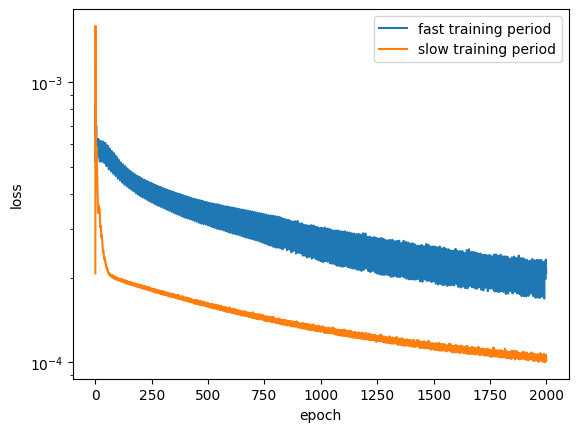

In [251]:
"""plot loss curve"""
plt.plot(BP_train_fast.loss_list[0:], label="fast training period")
plt.plot(BP_train_slow.loss_list[0:], label="slow training period")
plt.yscale("log")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()

In [253]:
"""data prepartion for prediction test"""
n_prediction_steps = 40000
initial_piece_len = time_delay*(time_delay_dim-1) + 1
prediction_start_after = 1100 # set to any number that is larger enough to avoid effects of initial states.
initial_piece_test = V_test[prediction_start_after:prediction_start_after+initial_piece_len]

In [262]:
"""prediction with RBF + ANN model"""
pred_run1_batch = lib.time_series_prediction(pred_model, time_delay, time_delay_dim, time_delay, time_delay_dim, I_test[prediction_start_after:], initial_piece_test)
pred_run1_batch.run(params, n_steps=n_prediction_steps)

100%|██████████| 38449/38449 [1:03:13<00:00, 10.14it/s]


In [267]:
"""prediction with RBF only model"""
pred_model_rbf_only = lib.models.prediction_model_no_ann(time_spacing, R, centers, weights_rbf, mlp, weights_leak, weight_C_inverse)
pred_run0_batch = lib.time_series_prediction(pred_model_rbf_only, time_delay, time_delay_dim, time_delay, time_delay_dim, I_test[prediction_start_after:], initial_piece_test)
pred_run0_batch.run(params, n_steps=n_prediction_steps)

100%|██████████| 38449/38449 [07:15<00:00, 88.28it/s]


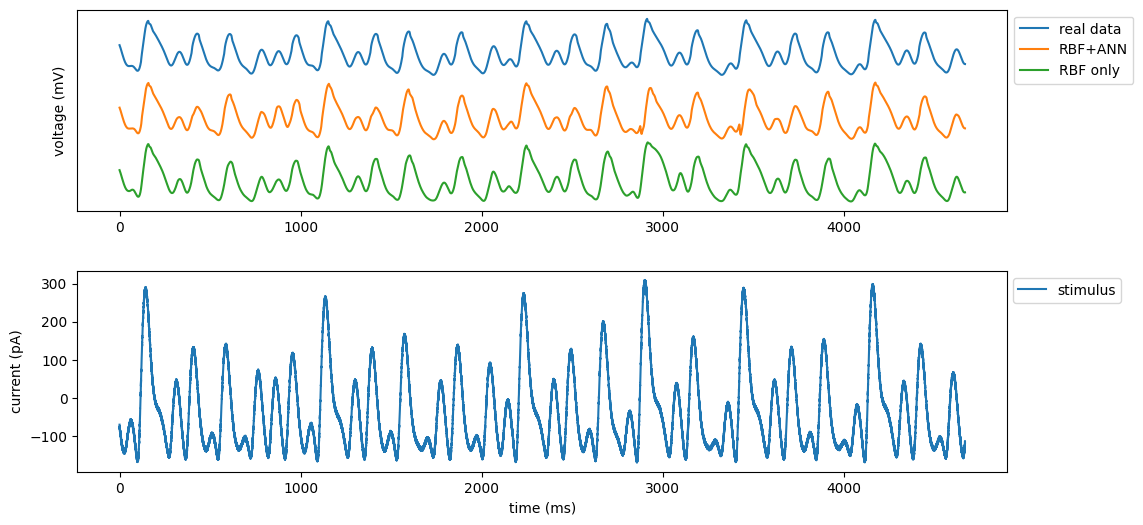

In [268]:
start = initial_piece_len + -initial_piece_len 
end = min(I_test.shape[-1]-prediction_start_after, initial_piece_len + n_prediction_steps)

fig, axes = plt.subplots(2, 1, figsize=(12, 6))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
axes[0].plot(np.arange(end-start)*time_spacing, V_test[prediction_start_after+start: prediction_start_after+end]+0, label="real data")
axes[0].plot(np.arange(end-start)*time_spacing, pred_run1_batch.prediction_list[0,start:end]-130, label="RBF+ANN")
axes[0].plot(np.arange(end-start)*time_spacing, pred_run0_batch.prediction_list[0,start:end]-260, label="RBF only")
axes[0].set_yticks([])
axes[0].set_ylabel("voltage (mV)")
# axes[2*i].set_ylim(-440, 100)
axes[0].legend(bbox_to_anchor=(1,1))

axes[1].plot(np.arange(end-start)*time_spacing, I_test[prediction_start_after+start: prediction_start_after+end], label="stimulus")
axes[1].set_xlabel("time (ms)")
axes[1].set_ylabel("current (pA)")
axes[1].legend(bbox_to_anchor=(1.13,1))

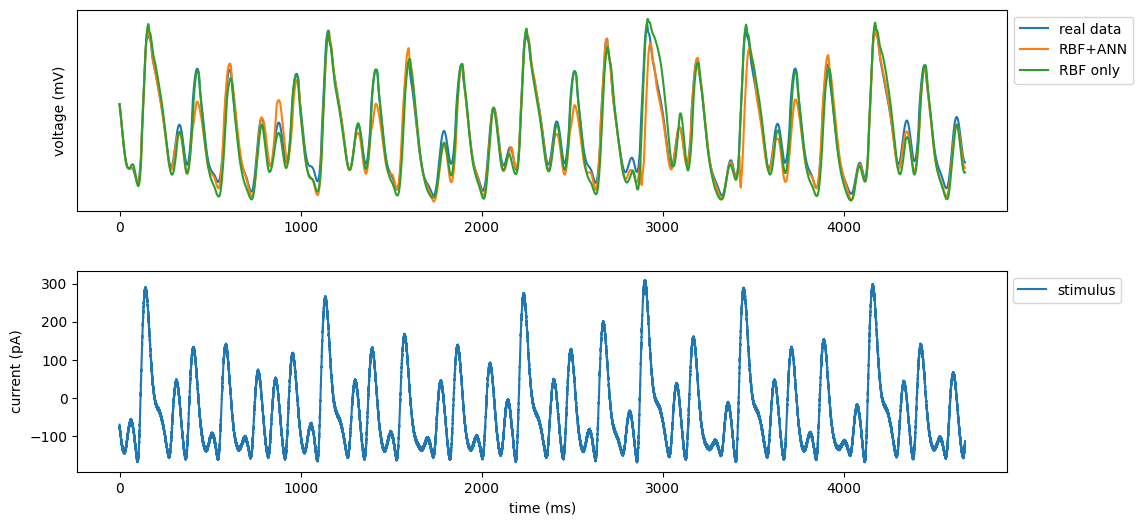

In [270]:
start = initial_piece_len + -initial_piece_len 
end = min(I_test.shape[-1]-prediction_start_after, initial_piece_len + n_prediction_steps)

fig, axes = plt.subplots(2, 1, figsize=(12, 6))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
axes[0].plot(np.arange(end-start)*time_spacing, V_test[prediction_start_after+start: prediction_start_after+end]+0, label="real data")
axes[0].plot(np.arange(end-start)*time_spacing, pred_run1_batch.prediction_list[0,start:end], label="RBF+ANN")
axes[0].plot(np.arange(end-start)*time_spacing, pred_run0_batch.prediction_list[0,start:end], label="RBF only")
axes[0].set_yticks([])
axes[0].set_ylabel("voltage (mV)")
# axes[2*i].set_ylim(-440, 100)
axes[0].legend(bbox_to_anchor=(1,1))

axes[1].plot(np.arange(end-start)*time_spacing, I_test[prediction_start_after+start: prediction_start_after+end], label="stimulus")
axes[1].set_xlabel("time (ms)")
axes[1].set_ylabel("current (pA)")
axes[1].legend(bbox_to_anchor=(1.13,1))